In [1]:
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import pickle
import numpy as np
import training
import config
import matplotlib.pyplot as plt
import FigureConfig as FC
import pandas
from scipy import optimize as op
import math

In [2]:
with open('./data/inv_dataset.p', 'rb') as file:
    a = pickle.load(file)

In [3]:
X, Y = a['X'], a['Y']
Xn, Yn = a['Xn'], a['Yn']
X_min, X_max = a['X_min'], a['X_max']
Y_min, Y_max = a['Y_min'], a['Y_max']

X_learn, Y_learn = a['X_learn'], a['Y_learn']
X_train, Y_train = a['X_train'], a['Y_train']
X_valid, Y_valid = a['X_valid'], a['Y_valid']
X_test , Y_test  = a['X_test'] , a['Y_test']

Xn_learn, Yn_learn = a['Xn_learn'], a['Yn_learn']
Xn_train, Yn_train = a['Xn_train'], a['Yn_train']
Xn_valid, Yn_valid = a['Xn_valid'], a['Yn_valid']
Xn_test , Yn_test  = a['Xn_test'] , a['Yn_test']

# Convert `X` with unit ${\rm [Ohm,\, Ohm,\, kOhm,\, kOhm,\, kOhm,\, \mu m,\, \mu m]}$

In [4]:
Y = Y.numpy()

In [5]:
X_show = X[:,:7].numpy()
X_show[:,0] = X_show[:,0]
X_show[:,1] = X_show[:,1]
X_show[:,2] = X_show[:,2]/1e3
X_show[:,3] = X_show[:,3]/1e3
X_show[:,4] = X_show[:,4]/1e3
X_show[:,5] = X_show[:,5]*1e6
X_show[:,6] = X_show[:,6]*1e6
X = X_show

# Visualization of inv

In [6]:
def inv(eta):
    x = np.linspace(-2,2,1000)
    y = - (eta[0] + eta[1] * np.tanh((x - eta[2]) * eta[3]))
    return x, y

In [7]:
x1 = np.linspace(-2,2,100)
y1 = x1 * 0.
y2 = np.linspace(-2,2,100)
x2 = y2 * 0.

inv_vis = [37, 61, 211]
act_vis = [76, 95, 169]

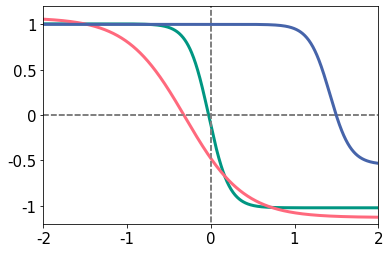

In [8]:
for idx, i in enumerate(inv_vis):
    plt.plot(x1,y1,'--',c='gray')
    plt.plot(x2,y2,'--',c='gray')
    plt.plot(inv(Y[i,:])[0], inv(Y[i,:])[1], lw=3, c=FC.liste[idx])
    plt.xticks([-2, -1, 0, 1, 2], ['-2', '-1', '0', '1', '2'], fontsize=15)
    plt.yticks([-1, -0.5, 0, 0.5, 1], ['-1', '-0.5', '0', '0.5', '1'], fontsize=15)
    plt.xlim([-2,2])
    plt.ylim([-1.2,1.2])
# plt.savefig(f'../../figures/INV_example.pdf', format='pdf', bbox_inches='tight')
plt.show()

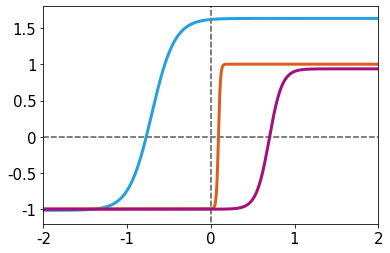

In [9]:
for idx, i in enumerate(act_vis):
    plt.plot(x1,y1,'--',c='gray')
    plt.plot(x2,y2,'--',c='gray')
    plt.plot(inv(Y[i,:])[0], -inv(Y[i,:])[1], lw=3, c=FC.liste[idx+6])
    plt.xticks([-2, -1, 0, 1, 2], ['-2', '-1', '0', '1', '2'], fontsize=15)
    plt.yticks([ -1, -0.5, 0, 0.5, 1, 1.5], ['-1', '-0.5', '0', '0.5', '1', '1.5'], fontsize=15)
    plt.xlim([-2,2])
    plt.ylim([-1.2, 1.8])
# plt.savefig(f'../../figures/ACT_example.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Visualization for NN

In [4]:
X, Y = a['X'], a['Y']
Xn, Yn = a['Xn'], a['Yn']
X_min, X_max = a['X_min'], a['X_max']
Y_min, Y_max = a['Y_min'], a['Y_max']

X_learn, Y_learn = a['X_learn'], a['Y_learn']
X_train, Y_train = a['X_train'], a['Y_train']
X_valid, Y_valid = a['X_valid'], a['Y_valid']
X_test , Y_test  = a['X_test'] , a['Y_test']

Xn_learn, Yn_learn = a['Xn_learn'], a['Yn_learn']
Xn_train, Yn_train = a['Xn_train'], a['Yn_train']
Xn_valid, Yn_valid = a['Xn_valid'], a['Yn_valid']
Xn_test , Yn_test  = a['Xn_test'] , a['Yn_test']

In [5]:
eta_estimator = torch.load(f'../../LNC/NN/model.nlc')

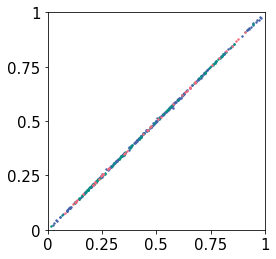

In [11]:
prediction_train = eta_estimator(Xn_train)
prediction_valid = eta_estimator(Xn_valid)
prediction_test = eta_estimator(Xn_test)

lossfunction = torch.nn.MSELoss()
loss_train = lossfunction(Yn_train, prediction_train)
loss_valid = lossfunction(Yn_valid, prediction_valid)
loss_test  = lossfunction(Yn_test,  prediction_test)

plt.figure()
# plt.plot(np.linspace(0,1,100), np.linspace(0,1,100),  c='black')
plt.scatter(Yn_train[::100].flatten().numpy(), prediction_train[::100].detach().flatten().numpy(), s=2, color=FC.Blue, label=f'train_loss: {loss_train:.2e}')
plt.scatter(Yn_valid[::100].flatten().numpy(), prediction_valid[::100].detach().flatten().numpy(), s=2, color=FC.Green, label=f'valid_loss: {loss_valid:.2e}')
plt.scatter(Yn_test[::100].flatten().numpy(), prediction_test[::100].detach().flatten().numpy(), s=2, color=FC.Pink, label=f'test_loss: {loss_test:.2e}')
plt.xlim([0, 1])
plt.ylim([0, 1])
ax = plt.gca()
ax.set_aspect(1)
plt.xticks([0, 0.25, 0.5, 0.75, 1], ['0', '0.25', '0.5', '0.75', '1'], fontsize=15)
plt.yticks([0, 0.25, 0.5, 0.75, 1], ['0', '0.25', '0.5', '0.75', '1'], fontsize=15)
# plt.legend(fontsize=12)
plt.savefig(f'../../figures/final_INV_result.pdf', format='pdf', bbox_inches='tight')
plt.show()

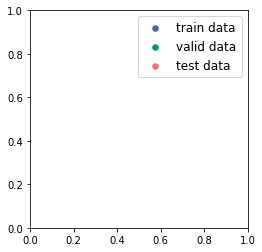

In [66]:
plt.figure()
plt.scatter(Yn_train.flatten().numpy(), prediction_train.detach().flatten().numpy()*0-1, s=30, color=FC.Blue, label=f'train data')
plt.scatter(Yn_valid.flatten().numpy(), prediction_valid.detach().flatten().numpy()*0-1, s=30, color=FC.Green, label=f'valid data')
plt.scatter(Yn_test.flatten().numpy(), prediction_test.detach().flatten().numpy()*0-1, s=30, color=FC.Pink, label=f'test data')
plt.xlim([0, 1])
plt.ylim([0, 1])
ax = plt.gca()
ax.set_aspect(1)
plt.legend(fontsize=12)
plt.savefig(f'../../figures/final_INV_legend.pdf', format='pdf', bbox_inches='tight')
plt.show()

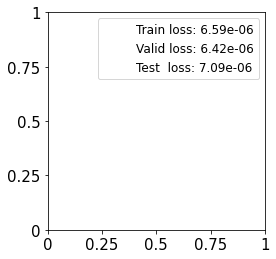

In [71]:
plt.figure()
plt.scatter(Yn_train.flatten().numpy(), prediction_train.detach().flatten().numpy()*0-1, s=0, color=FC.Blue, label=f'Train loss: {loss_train:.2e}')
plt.scatter(Yn_valid.flatten().numpy(), prediction_valid.detach().flatten().numpy()*0-1, s=0, color=FC.Green, label=f'Valid loss: {loss_valid:.2e}')
plt.scatter(Yn_test.flatten().numpy(), prediction_test.detach().flatten().numpy()*0-1, s=0, color=FC.Pink, label=f'Test  loss: {loss_test:.2e}')
plt.xlim([0, 1])
plt.ylim([0, 1])
ax = plt.gca()
ax.set_aspect(1)
plt.xticks([0, 0.25, 0.5, 0.75, 1], ['0', '0.25', '0.5', '0.75', '1'], fontsize=15)
plt.yticks([0, 0.25, 0.5, 0.75, 1], ['0', '0.25', '0.5', '0.75', '1'], fontsize=15)
plt.legend(fontsize=12)
plt.savefig(f'../../figures/final_INV_value.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Visualization for fitting

In [21]:
data = pandas.read_csv('../result/invW_10000.csv')
npdata = data.to_numpy()

/opt/bwhpc/common/jupyter/base/2022-03-30/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3106: DtypeWarning: Columns (3043,3044) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [53]:
def f(x, eta1,eta2,eta3,eta4):
    return eta1 +eta2*np.tanh((x-eta3)*eta4)
x=np.linspace(-2,2,4001)

In [54]:
example = 133
f1 = npdata[:,example]
eta1,eta2,eta3,eta4 = op.curve_fit(f, x, f1, p0=[0.,-1.,0.,-1.])[0]

In [55]:
N = 15
l = np.linspace(0,1,N)
y1 = l**2 * 2000
y2 = - l[1:]**2 * 2000
y2 = np.append(y2, y1)
y2 = np.round(y2).astype(int)
y2 = np.unique(y2)
y2.sort()
idx = y2 + 1900

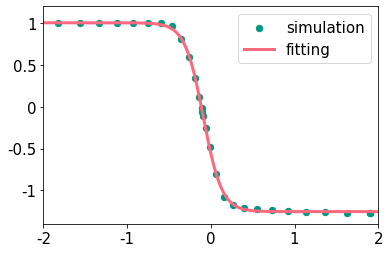

In [57]:
plt.figure()
plt.scatter(x[idx], f1[idx],color=FC.Green,label='simulation', s=40)
ys = eta1 + eta2 * np.tanh((x - eta3) * eta4)
plt.plot(x, ys,color=FC.Pink,lw=3, label='fitting')
plt.xticks([-2, -1, 0, 1, 2], ['-2', '-1', '0', '1', '2'], fontsize=15)
plt.yticks([ -1, -0.5, 0, 0.5, 1, 1.5], ['-1', '-0.5', '0', '0.5', '1', '1.5'], fontsize=15)
plt.xlim([-2,2])
plt.ylim([-1.4, 1.2])
plt.legend(fontsize=15)
plt.savefig(f'../../figures/fitting.pdf', format='pdf', bbox_inches='tight')
plt.show()